En este notebook, se procesan y analizan los resultados obtenidos

In [1]:
import os
import pickle

from ast import literal_eval
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures, TrigramCollocationFinder, TrigramAssocMeasures
from gensim.models import Word2Vec, FastText
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


NUM_TOPICS=120
topics = range(0, NUM_TOPICS, 1)

TEXT_FILE_READ = 'docs/reddit_data_hate_speech.csv'
HATE_WORDS = 'docs/palabras_odio.csv'
TOPIC_TEST_FOLDER = 'docs/test/hstopic/'

os.makedirs(TOPIC_TEST_FOLDER, exist_ok=True)
np.random.seed(42)

In [2]:
reddit = pd.read_csv(TEXT_FILE_READ)
hate_words = pd.read_csv(HATE_WORDS)

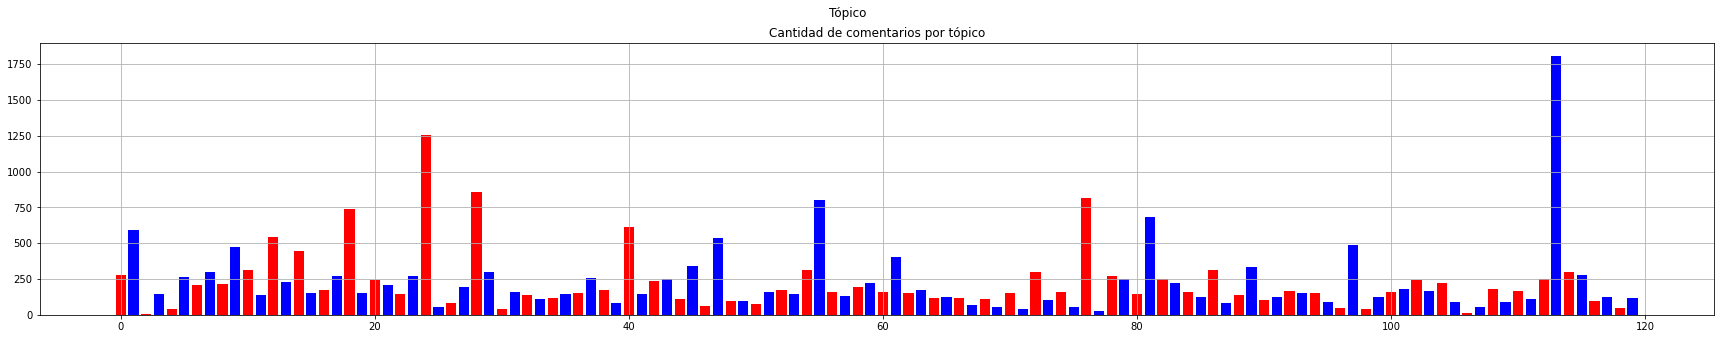

In [3]:
fig, (ax4) = plt.subplots(1, 1,figsize=(30,5))
fig.suptitle('Tópico ')

New_Colors = ['red','blue'] * int(NUM_TOPICS/2)

topics_range = range(0, NUM_TOPICS, 1)

topics_count = []

for i in range(NUM_TOPICS):
    temp = reddit.loc[(reddit["cluster"] == str([i]))]
    topics_count.append(len(temp))
    
ax4.bar(topics_range, topics_count, color=New_Colors)
ax4.set_title('Cantidad de comentarios por tópico')
ax4.grid(True)

In [4]:
def get_counts_words(reddit):
    words_hate_speech = []

    for sent in reddit['body_preprocessing']:
        for word in str(sent).split():
            words_hate_speech.append(word)
    return Counter(words_hate_speech)

In [5]:
def plot_word_cloud(topic_list):
    data = {'topic': [], 'score_hate_speech': [], 'score_not_hate_speech': [], 'comms_num_hate_speech': [], 'comms_num_not_hate_speech': []}
    df_marks = pd.DataFrame(data)
    
    for topic in topic_list:
        reddit_hate_speech = reddit.loc[(reddit["cluster"] == str([topic])) & (reddit["hate_speech"] == "si")]
        reddit_not_hate_speech = reddit.loc[(reddit["cluster"] == str([topic])) & (reddit["hate_speech"] == "no")]

        reddit_hate_speech.to_csv(TOPIC_TEST_FOLDER + str(topic) + '_hp.csv')
        reddit_not_hate_speech.to_csv(TOPIC_TEST_FOLDER + str(topic) + '_nhp.csv')

        types = ['Hate Speech','Not Hate Speech']
        score = [reddit_hate_speech['score'].mean(),reddit_not_hate_speech['score'].mean()]
        num_comments = [reddit_hate_speech['comms_num'].mean(),reddit_not_hate_speech['comms_num'].mean()]
        New_Colors = ['red','blue']

        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5,figsize=(30,5))
        fig.suptitle('Tópico ' + str(topic))

        if len(reddit_hate_speech) > 0:
            ax1.imshow(WordCloud(random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords=STOPWORDS)
                       .fit_words(get_counts_words(reddit_hate_speech)))
        ax1.axis("off")
        ax1.set_title('Palabras Hate Speech')

        if len(reddit_not_hate_speech) > 0:
            ax2.imshow(WordCloud(random_state=1, background_color='navy', colormap='rainbow', collocations=False, stopwords=STOPWORDS)
                       .fit_words(get_counts_words(reddit_not_hate_speech)))
        ax2.axis("off")
        ax2.set_title('Palabras Not Hate Speech')

        ax3.bar(types, score, color=New_Colors)
        ax3.set_title('Puntaje promedio')
        ax3.grid(True)

        ax4.bar(types, num_comments, color=New_Colors)
        ax4.set_title('Números de comentarios promedio')
        ax4.grid(True)

        ax5.bar(types, [len(reddit_hate_speech), len(reddit_not_hate_speech)], color=New_Colors)
        ax5.set_title('Números de comentarios Clasificador por odio y no odio')
        ax5.grid(True)

        new_row = {'topic':topic, 'score_hate_speech':score[0], 'score_not_hate_speech':score[1], 'comms_num_hate_speech':num_comments[0], 'comms_num_not_hate_speech':num_comments[1]}
        df_marks = df_marks.append(new_row, ignore_index=True)
    
    return df_marks

In [6]:
def calcular_distancias(topic_list, model, kmeans):
    distances = {}
    
    for word in pd.Series([hate_words['hateval_rf'], hate_words['hateval_nb'],
                    hate_words['detoxis_rf'], hate_words['detoxis_nb'],
                    hate_words['meoffendmex_rf'], hate_words['meoffendmex_nb']]).iloc[0]:
        word_distance_per_topic = []
        for topic in topic_list:
            try:
                word_distance_per_topic.append(np.linalg.norm(model.wv.get_vector(word) - kmeans.cluster_centers_[topic]))
            except KeyError:
                word_distance_per_topic.append(np.inf)
        distances[word] = word_distance_per_topic
    
    return distances

In [7]:
def ver_palabras_asociadas(palabras_asociadas, embedding, clustering_model):
    for palabra_asociada in palabras_asociadas:
        print('Palabra: {}'.format(palabra_asociada))
        print('Clúster: {}'.format(clustering_model.predict(np.array([embedding.wv.get_vector(palabra_asociada)], dtype=float))))
        print('Términos cercanos: {} \n'.format(embedding.wv.most_similar(palabra_asociada)))

In [8]:
bigram_measures = BigramAssocMeasures()  # definimos la métrica de asociación de los bigramas
score = bigram_measures.pmi  # (en este caso, pointwise mutual information)

trigram_measures = TrigramAssocMeasures()  # hacemos lo mismo para los trigramas
score = trigram_measures.pmi

In [9]:
# basado en https://github.com/IsabelRivadero/text_minning/blob/main/Detecci%C3%B3nDeIndicadoresDePrejuiciosDeG%C3%A9neroParaPedidoDeClarificaci%C3%B3n_entrega.ipynb

selected_cluster = 17

reddit_words_all = reddit[reddit["cluster"] == str([selected_cluster])]['lemma_tokens'].apply(literal_eval)
reddit_words_hate = reddit[(reddit["cluster"] == str([selected_cluster])) &
                      (reddit["hate_speech"]=="si")]['lemma_tokens'].apply(literal_eval)
bigram_finder = BigramCollocationFinder.from_documents(reddit_words_all)
trigram_finder = TrigramCollocationFinder.from_documents(reddit_words_all)
bigram_finder.apply_freq_filter(2)  # limitamos la cantidad mínima de palabras que deben aparecer
trigram_finder.apply_freq_filter(2)

TODO si hay suficientes bigramas, hacer el mismo proceso de info mutua que con los unigramas

In [10]:
reddit_words_counter_all = Counter(sum(list(reddit_words_all),[]))
reddit_words_counter_hate = Counter(sum(list(reddit_words_hate),[]))

In [11]:
word_pmis = {}

for word in reddit_words_counter_hate:
    
    try:
        number_of_messages_with_word = reddit['body_preprocessing'].str.contains(word).value_counts()[1]
        number_of_hate_msg_with_word = reddit[reddit["hate_speech"]=="si"]['body_preprocessing'].str.contains(word).value_counts()[1]
    except:
        continue
        
    if number_of_messages_with_word >= 5:  # minimum threshold for consider the word
        word_pmis[word] = np.log2(number_of_hate_msg_with_word / (number_of_messages_with_word * len(reddit[reddit["hate_speech"]=="si"])))


In [12]:
word_pmis_sorted = sorted(word_pmis.items(),key=lambda x:x[1], reverse=True)
word_pmis_sorted

[('hijar', -11.603858121842805),
 ('tomalo', -11.826250543179253),
 ('pario', -12.018895621121649),
 ('k5n', -12.018895621121649),
 ('mierdo', -12.081631376469613),
 ('mierda', -12.17292924979407),
 ('mierdar', -12.19577338320573),
 ('puto', -12.291914115528066),
 ('simio', -12.299003540314384),
 ('placa', -12.340823716009012),
 ('loko', -12.340823716009012),
 ('pedofilo', -12.340823716009012),
 ('hdp', -12.361287818568728),
 ('presidente', -12.37119736505253),
 ('puta_madre', -12.37253257573635),
 ('gordo', -12.388129430787368),
 ('madre', -12.412559469607926),
 ('abrio', -12.433933120400493),
 ('concha', -12.54941033782043),
 ('inmundo', -12.603858121842805),
 ('cagón', -12.603858121842805),
 ('ladrillo', -12.603858121842805),
 ('invasor', -12.603858121842805),
 ('mosca', -12.603858121842805),
 ('piedras', -12.603858121842805),
 ('petiso', -12.755861215287856),
 ('culo', -12.759977323760088),
 ('golosa_paz', -12.826250543179253),
 ('ponetir', -12.925786216730168),
 ('realidad', -12.9

In [13]:
bigrams = {'_'.join(bigram): pmi for bigram, pmi in bigram_finder.score_ngrams(score)}
trigrams = {'_'.join(trigram): pmi for trigram, pmi in trigram_finder.score_ngrams(score)}

In [14]:
bigram_finder.nbest(bigram_measures.pmi, 20)

[('2000', '6_més'),
 ('6_més', 'hacermir'),
 ('animaste', 'vulnerable'),
 ('aprovechen', 'tarado'),
 ('arresto_cristín', 'fernández'),
 ('barbero', 'semana'),
 ('charla', 'genero'),
 ('construccion', 'fundamental'),
 ('controversial', '~~realmente~~'),
 ('crecer', 'tasa'),
 ('democracia', 'pierdo'),
 ('elección', 'democracia'),
 ('fernández', 'kirchner'),
 ('fundamental', 'desarrollo'),
 ('ganastir', 'upvote'),
 ('gano', 'elección'),
 ('genero', 'obrero'),
 ('gorila', 'crecer'),
 ('importante', 'animaste'),
 ('influencer', 'accesible')]

In [15]:
trigram_finder.nbest(trigram_measures.pmi, 20)

[('2000', '6_més', 'hacermir'),
 ('animaste', 'vulnerable', 'permitirte'),
 ('aprovechen', 'tarado', 'separensir'),
 ('arresto_cristín', 'fernández', 'kirchner'),
 ('barbero', 'semana', '2000'),
 ('charla', 'genero', 'obrero'),
 ('construccion', 'fundamental', 'desarrollo'),
 ('controversial', '~~realmente~~', 'información'),
 ('elección', 'democracia', 'pierdo'),
 ('gano', 'elección', 'democracia'),
 ('genero', 'obrero', 'construccion'),
 ('gorila', 'crecer', 'tasa'),
 ('importante', 'animaste', 'vulnerable'),
 ('información', 'arresto_cristín', 'fernández'),
 ('obrero', 'construccion', 'fundamental'),
 ('oir', 'gorila', 'crecer'),
 ('semana', '2000', '6_més'),
 ('tarado', 'separensir', 'inviable'),
 ('vulnerable', 'permitirte', 'exponerte'),
 ('~~realmente~~', 'información', 'arresto_cristín')]

In [16]:
word2vec_model = Word2Vec.load('docs/models/word2vec.model')
fasttext_model = FastText.load('docs/models/fasttext.model')

with open('docs/models/word2vec_kmeans.model', 'rb') as f:
    word2vec_kmeans = pickle.load(f)
    
with open('docs/models/fasttext_kmeans.model', 'rb') as f:
    fasttext_kmeans = pickle.load(f)

In [17]:
hate_words = pd.read_csv(HATE_WORDS)

In [18]:
# probamos la cercanía con algunas palabras que pueden estar asociadas a discursos de odio
palabras_asociadas_odio = ['brian', 'mapuch', 'conurbano']

ver_palabras_asociadas(palabras_asociadas_odio, word2vec_model, word2vec_kmeans)

Palabra: brian
Clúster: [79]
Términos cercanos: [('asinación', 0.7658923864364624), ('colaborá', 0.7015342712402344), ('putaaaaaaaaaaaaaaaaaaa', 0.6902926564216614), ('restante', 0.6423727869987488), ('jennys', 0.6364542841911316), ('mooooñito', 0.6290871500968933), ('puta', 0.6204057931900024), ('rajan', 0.616100013256073), ('vigote', 0.6128687858581543), ('p\\*ta', 0.6080505847930908)] 

Palabra: mapuch
Clúster: [40]
Términos cercanos: [('lewis', 0.5329598784446716), ('lso', 0.5253345966339111), ('vivamo', 0.5033279061317444), ('usurpador', 0.501255214214325), ('rebajartir', 0.46339884400367737), ('territorio', 0.46232345700263977), ('hualar', 0.4510837197303772), ('patria', 0.4496549963951111), ('pseudo', 0.4492214322090149), ('combatiente', 0.44035089015960693)] 

Palabra: conurbano
Clúster: [47]
Términos cercanos: [('mandado', 0.5307294130325317), ('cruzatir', 0.5026227235794067), ('pasante', 0.47065386176109314), ('zárate', 0.45400989055633545), ('gendarm', 0.43794286251068115), 

In [19]:
# algunos topicos interesantes: [8, 13, 14, 18, 23, 44, 53, 59, 61, 64, 72, 73, 87, 94, 98, 99, 100, 104, 114]
topic_list = [8, 13, 14, 18, 23, 44, 53, 59, 61, 64, 72, 73, 87, 94, 98, 99, 100, 104, 114]
distances = calcular_distancias(topic_list, word2vec_model, word2vec_kmeans)

clusters_cercanos = []
primer_cluster_mas_frecuente = []

for key, value in distances.items():
    clusters_cercanos +=  list(np.argsort(distances[key])[:3])
    primer_cluster_mas_frecuente += list(np.argsort(distances[key])[:1])
    #print('{} - clústers más cercanos: {}'.format(key, np.argsort(distances[key])[:5]))

print('Top 3 clústers: {}\n'.format(Counter(clusters_cercanos)))
print('Top 1 clúster: {}'.format(Counter(primer_cluster_mas_frecuente)))

Top 3 clústers: Counter({15: 76, 0: 74, 16: 73, 3: 20, 2: 20, 5: 11, 8: 9, 7: 4, 10: 3, 13: 2, 18: 2, 11: 2, 1: 2, 4: 1, 9: 1})

Top 1 clúster: Counter({0: 73, 3: 11, 2: 7, 15: 4, 7: 1, 8: 1, 16: 1, 5: 1, 9: 1})


Algunos tópicos de los clústers:

- 17 - bronca
- 116 - insultos
- 99 - mujeres
- 106 - violencia?

Vemos algunos comentarios de ejemplo

In [20]:
pd.options.display.max_colwidth=200
num_cluster = 79

df_cluster = pd.read_csv('docs/test/w2v_comments_per_cluster/{}.csv'.format(num_cluster))

print(df_cluster['body'])
print('---------------\n abajo: detectados como hate speech \n-----------------')
print(reddit[(reddit["cluster"] == str([num_cluster])) & (reddit["hate_speech"] == "si")]['body'])

0                                                                                                                                                                        Y lo va a donar a la Fundación Dylan.
1      Era un irrespetuoso. , un tremendo hijo de puta. , un ignorante mentiroso. , un avaro y malcriado. , un jodido hinchapelotas. , un estúpido, un tarado. , un sorete mal cagado. , drogadicto y maricón.
2                                                                                                          Claro tiene sentido. Que bueno que al menos tenga la suficiente consciencia de si mismo tu hermano.
3                                                                                                                                                  Ufff en la escuela con uno de esos de 2, eras Ricardo Fort!
4                                                                                                                                                                           

Los vemos en nube de palabras en base a las detecciones del modelo:

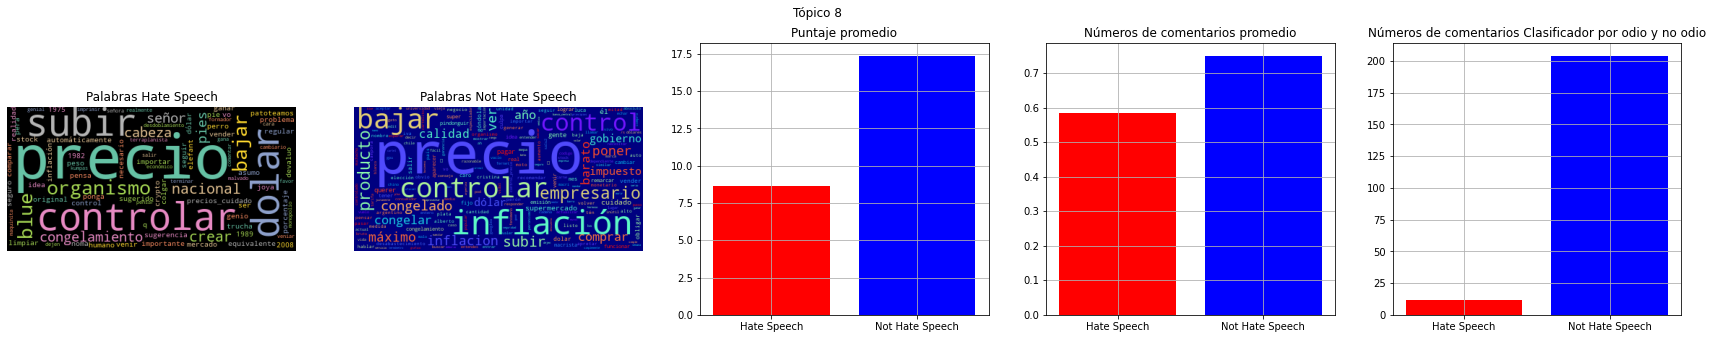

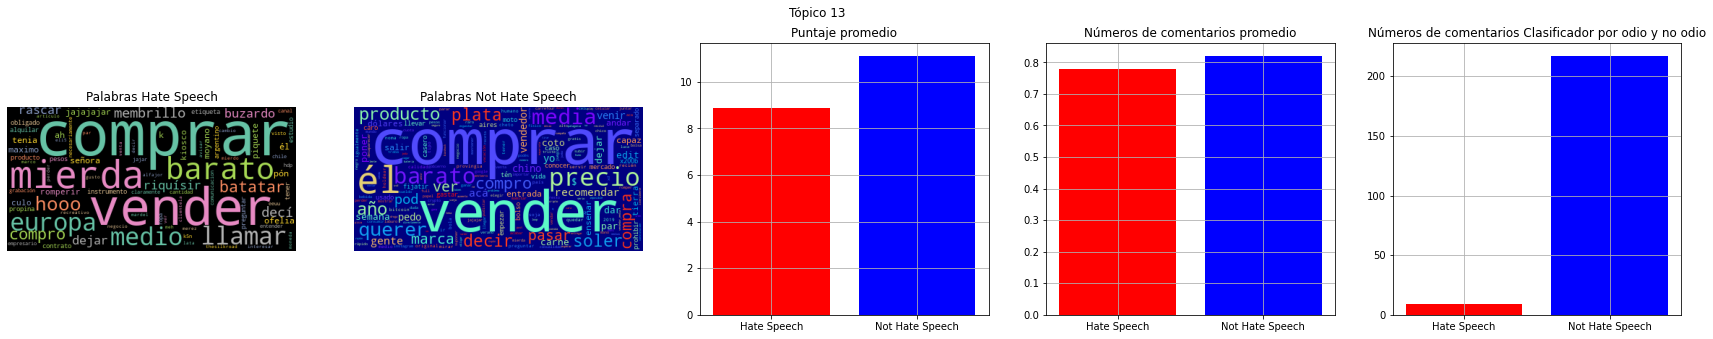

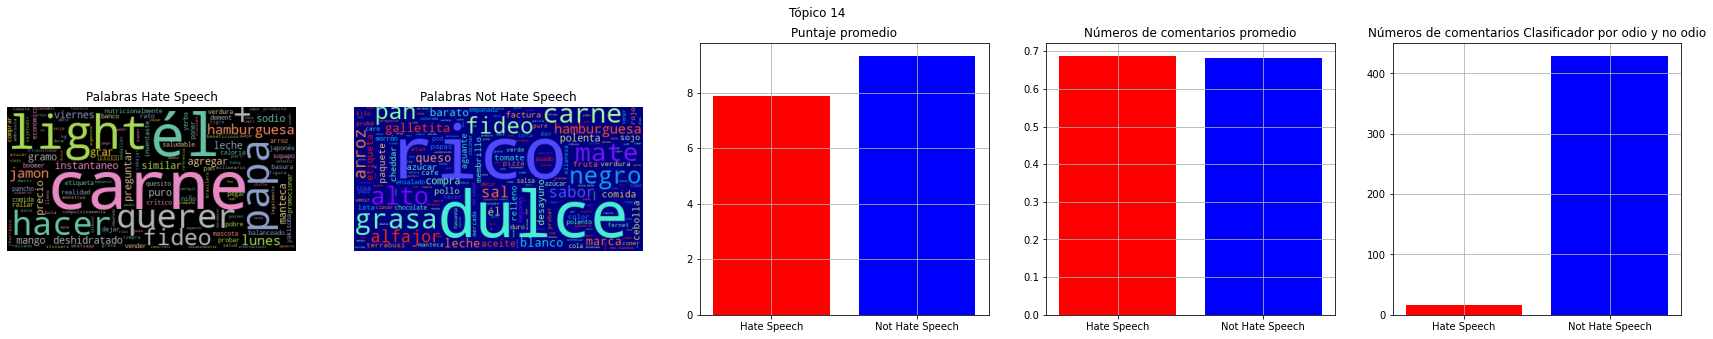

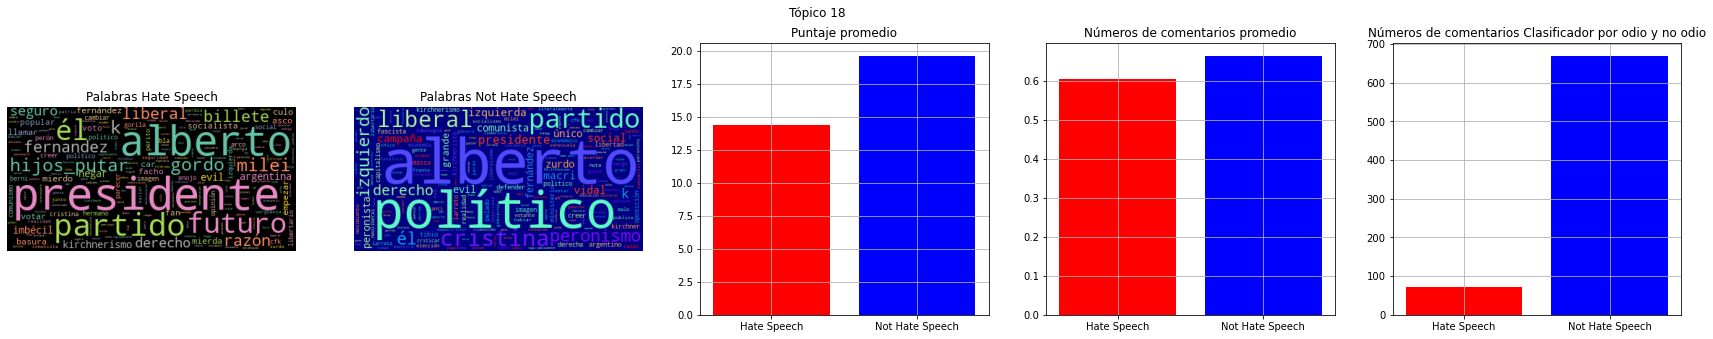

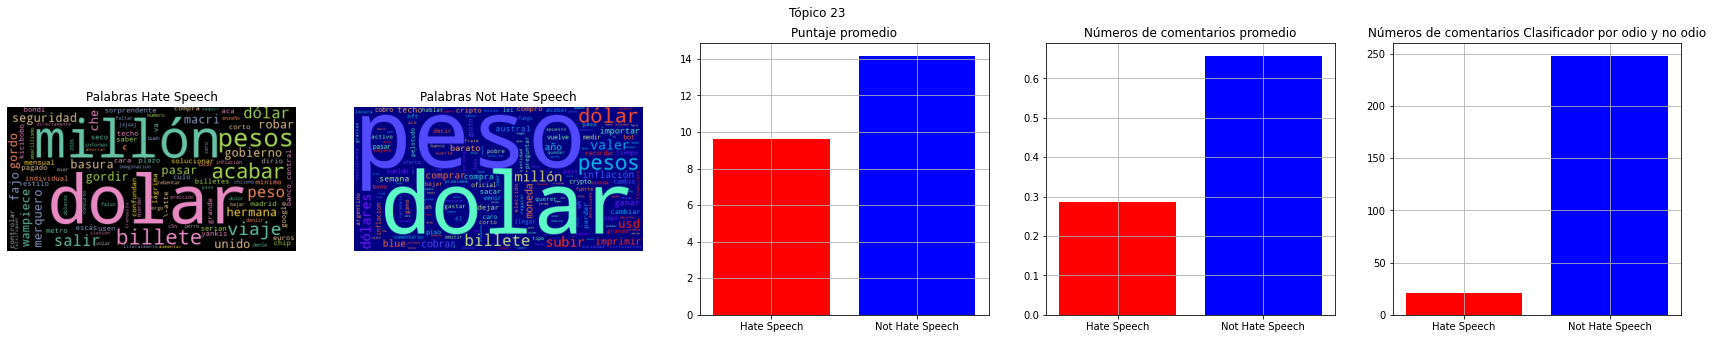

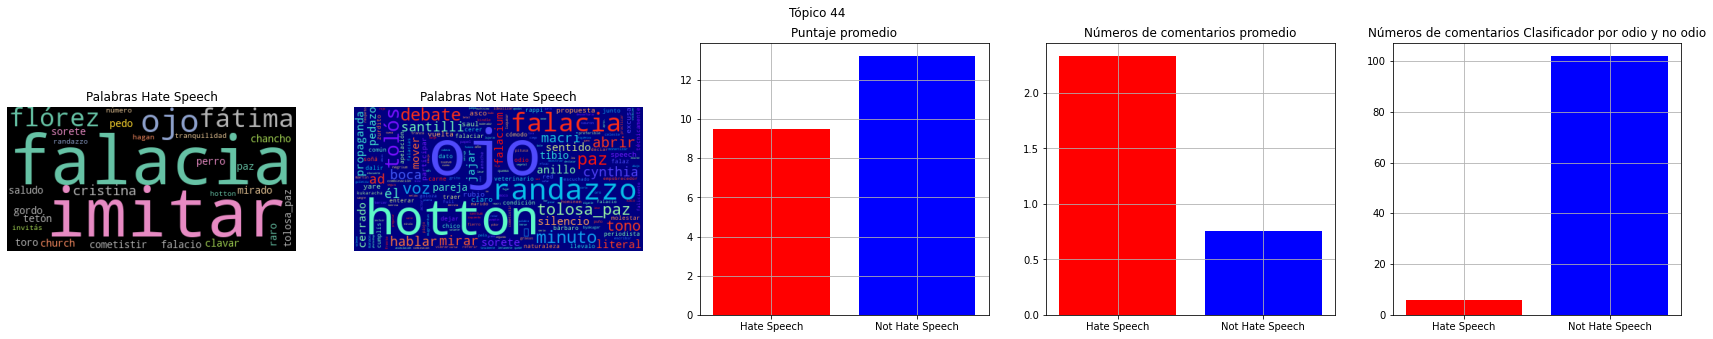

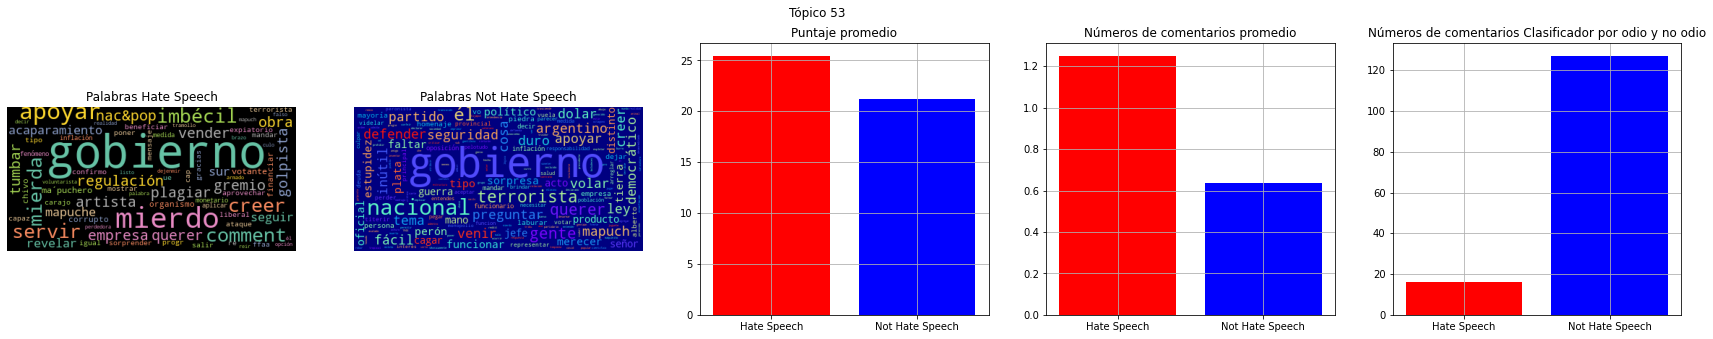

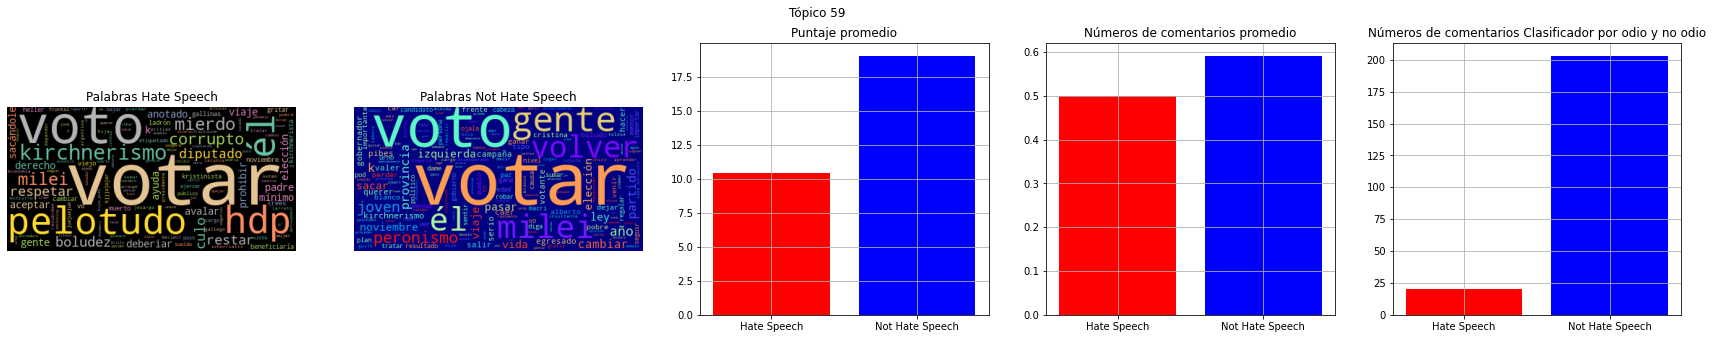

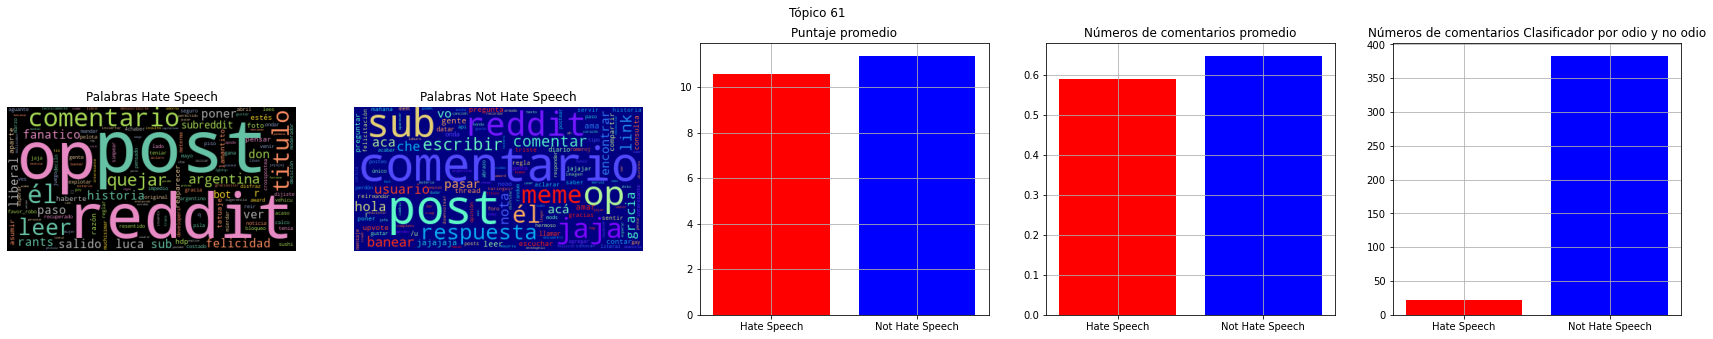

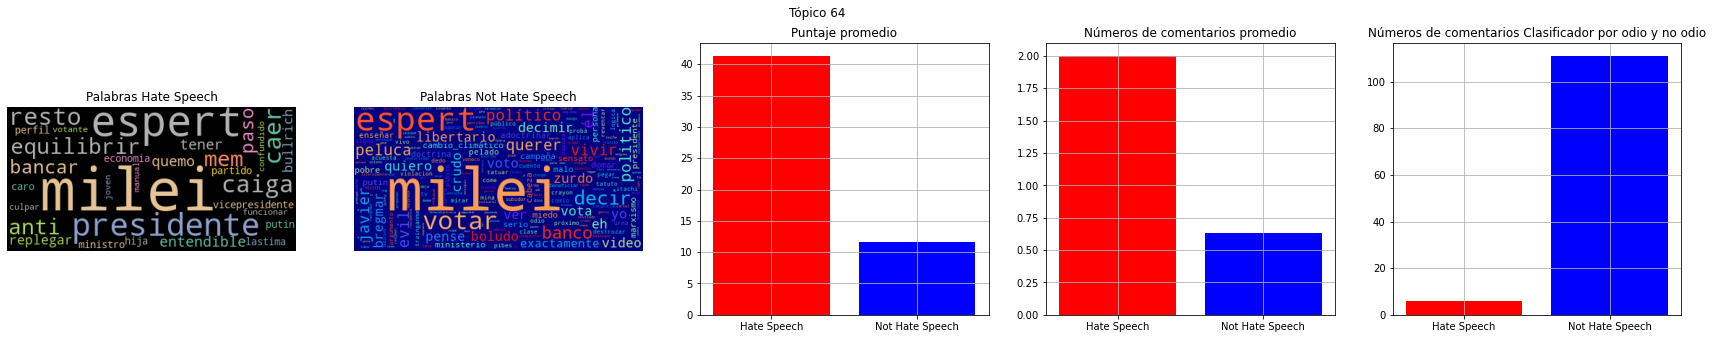

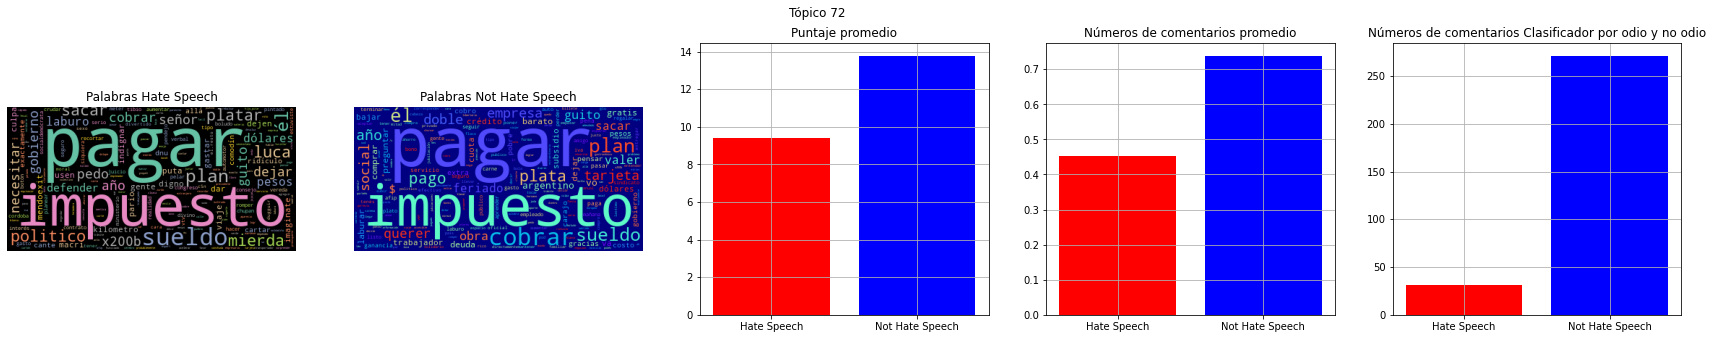

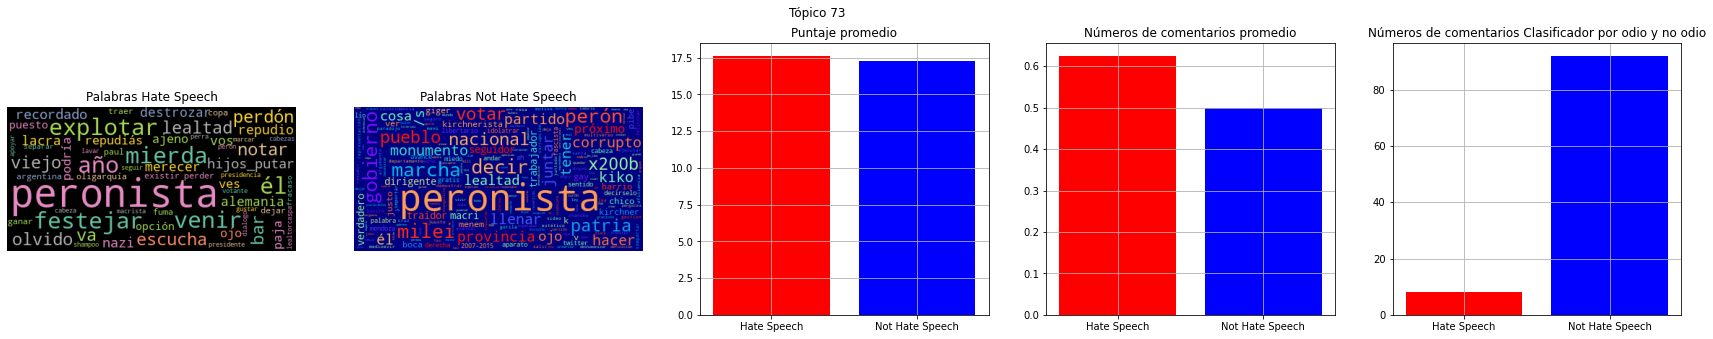

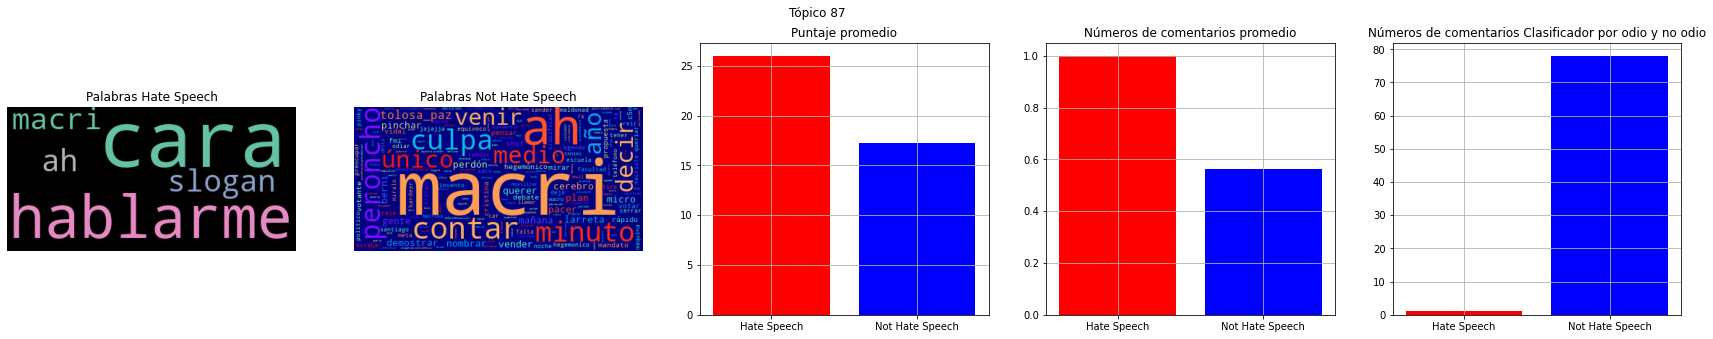

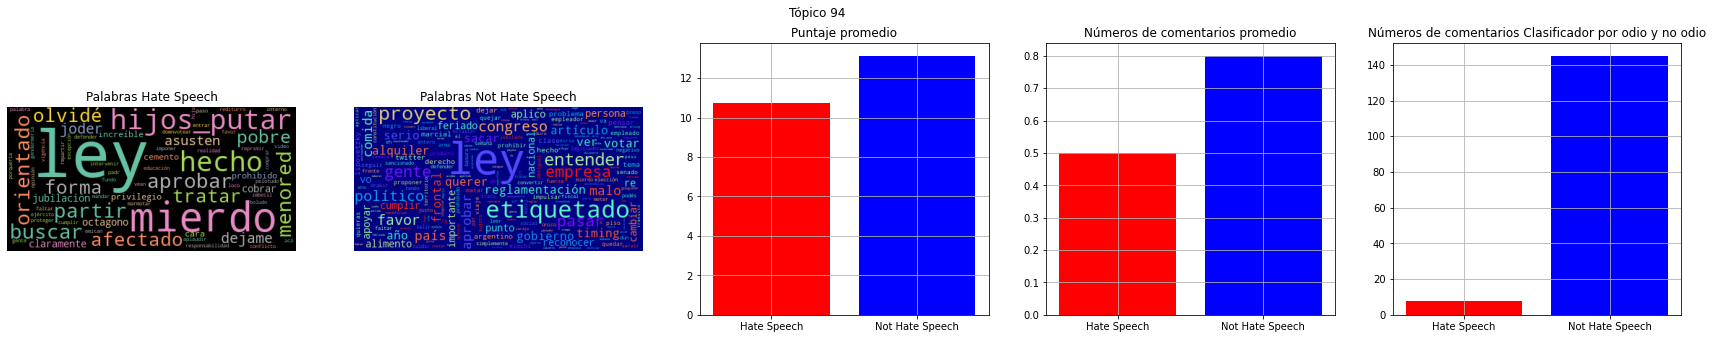

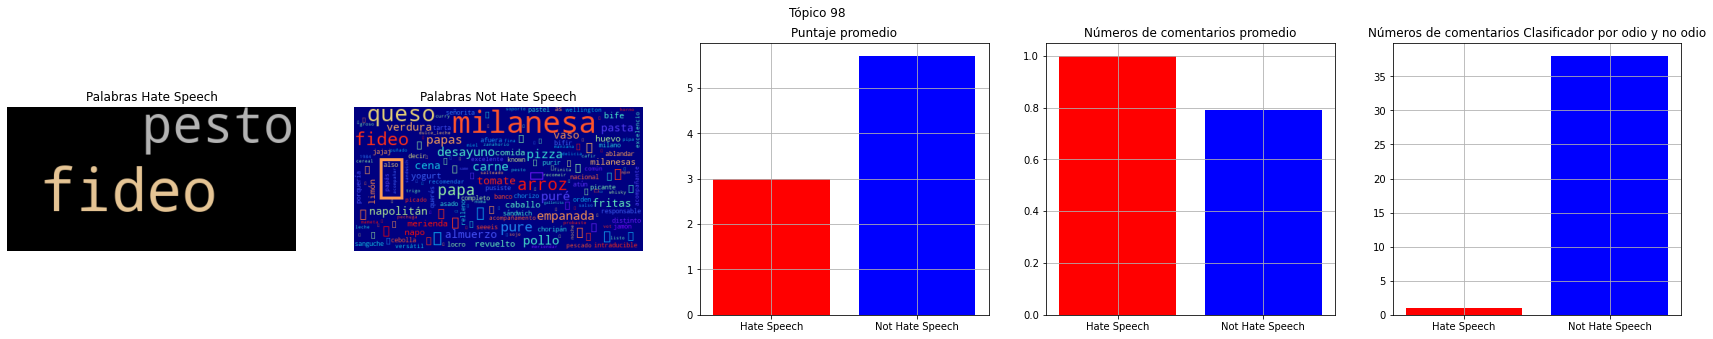

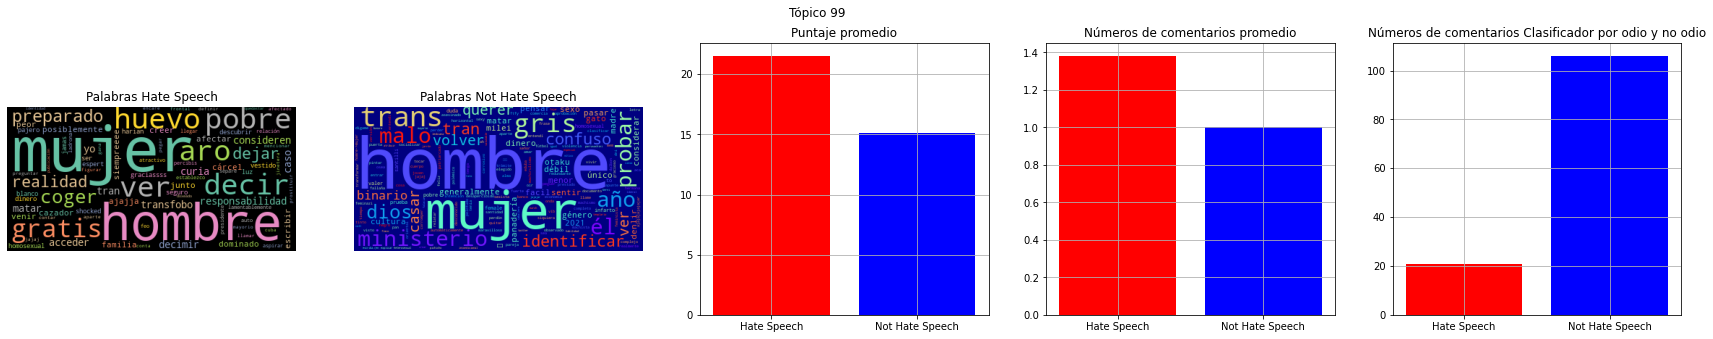

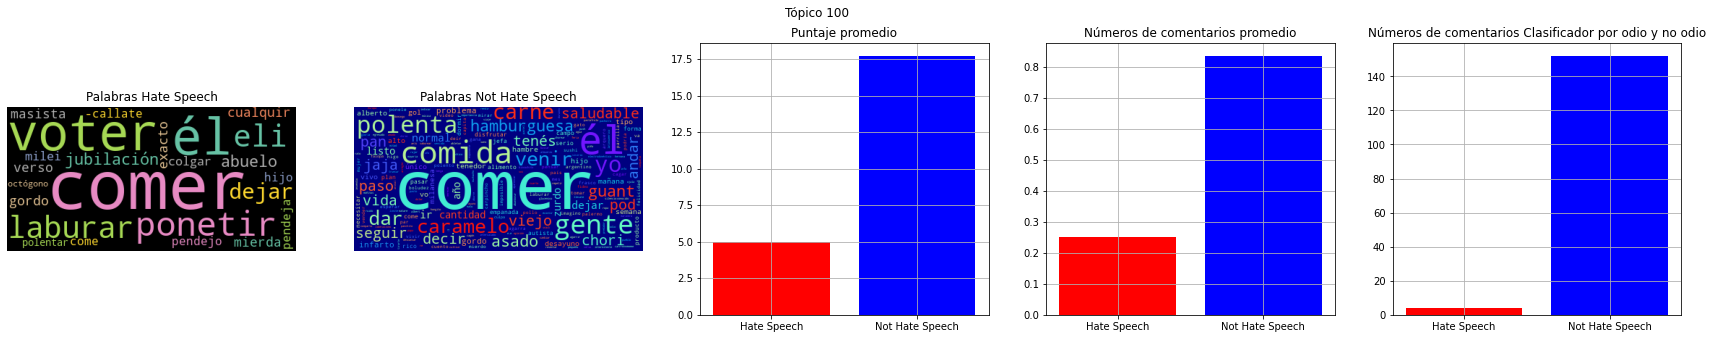

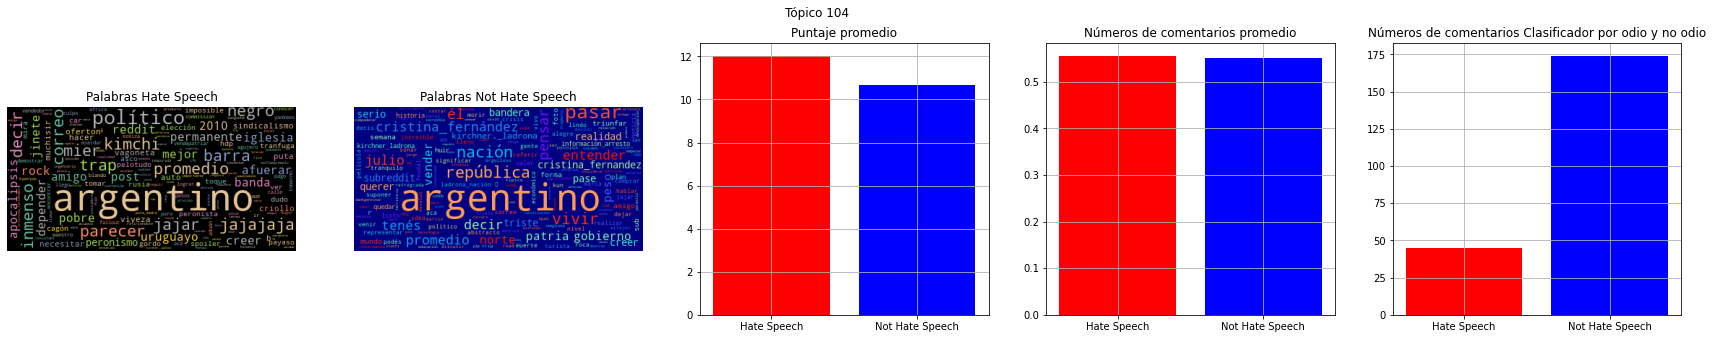

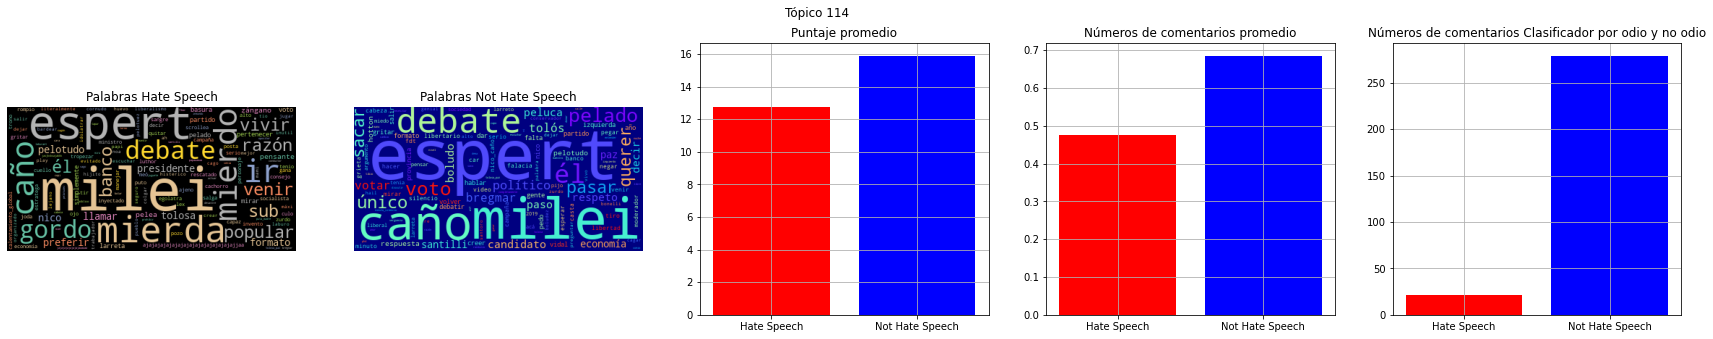

In [21]:
df_marks = plot_word_cloud([8, 13, 14, 18, 23, 44, 53, 59, 61, 64, 72, 73, 87, 94, 98, 99, 100, 104, 114])

In [22]:
df_marks.describe()

,topic,score_hate_speech,score_not_hate_speech,comms_num_hate_speech,comms_num_not_hate_speech
count,19.000000,19.000000,19.000000,19.000000,19.000000
mean,63.052632,13.935973,14.451549,0.834395,0.699979
std,34.899019,9.088327,3.938864,0.557466,0.119074
min,8.000000,3.000000,5.710526,0.250000,0.500000
25%,33.500000,9.137993,11.528309,0.500000,0.634213
50%,64.000000,10.590909,14.157258,0.605634,0.682984
75%,96.000000,15.988556,17.322398,1.000000,0.772188
max,114.000000,41.333333,21.181102,2.333333,1.000000


## FastText

In [23]:
# topicos interesantes: topics, 
distances = calcular_distancias(topic_list, fasttext_model, fasttext_kmeans)

clusters_cercanos = []
primer_cluster_mas_frecuente = []

for key, value in distances.items():
    clusters_cercanos +=  list(np.argsort(distances[key])[:3])
    primer_cluster_mas_frecuente += list(np.argsort(distances[key])[:1])
    #print('{} - clústers más cercanos: {}'.format(key, np.argsort(distances[key])[:5]))

print('Top 3 clústers: {}\n'.format(Counter(clusters_cercanos)))
print('Top 1 clúster: {}'.format(Counter(primer_cluster_mas_frecuente)))

Top 3 clústers: Counter({9: 78, 7: 63, 0: 37, 17: 34, 11: 15, 4: 12, 3: 10, 8: 9, 10: 7, 5: 6, 1: 6, 15: 5, 13: 5, 14: 3, 18: 3, 6: 3, 2: 3, 12: 1})

Top 1 clúster: Counter({9: 54, 7: 7, 10: 5, 4: 5, 11: 5, 3: 4, 17: 3, 1: 3, 5: 3, 0: 3, 14: 2, 8: 2, 13: 2, 15: 1, 2: 1})


In [24]:
ver_palabras_asociadas(palabras_asociadas_odio, fasttext_model, fasttext_kmeans)

Palabra: brian
Clúster: [64]
Términos cercanos: [('-brian', 0.922995388507843), ('irian', 0.7969086170196533), ('swan', 0.6158964037895203), ('evadian', 0.6045501828193665), ('bryan', 0.5873827934265137), ('harian', 0.58029705286026), ('kuriaki', 0.5745420455932617), ('dirian', 0.5599510669708252), ('myriam', 0.5391045212745667), ('julian', 0.5291886329650879)] 

Palabra: mapuch
Clúster: [84]
Términos cercanos: [('mapuchez', 0.960983395576477), ('mapuches', 0.9405418038368225), ('mapuche', 0.9384236335754395), ('mapuchecoin', 0.9315179586410522), ('mapu', 0.9219421148300171), ('mapuchir', 0.9190608859062195), ('pseudomapuch', 0.9139081835746765), ('pseudo-mapuches', 0.882238507270813), ('no-mapuches', 0.8731439113616943), ('pseudomapuche', 0.8623436093330383)] 

Palabra: conurbano
Clúster: [13]
Términos cercanos: [('conourbano', 0.9137831330299377), ('congourbano', 0.9039790630340576), ('conurba', 0.8694778680801392), ('conurbanense', 0.8258385062217712), ('urbano', 0.7487059831619263)

Algunos tópicos encontrados:

- 2 - insultos (comentarios 235 y 238 son hate)
- 50 - insultos también (no hate)

Vemos algunos comentarios de ejemplo

In [25]:
num_cluster = 62

df_cluster = pd.read_csv('docs/test/fasttext_comments_per_cluster/{}.csv'.format(num_cluster))
print(df_cluster['body'])

0                               No puedo dejar de pensar en los mini jorgito desde el exilio.. (y repetir cual locutro comercial de los 90, "Jorgito, el alfajor de los campeooones")
1                                                                                                 a alex caniggia lo habian funado rn cronica por este chiste sjsjjs, terrible cringe
2                                       Por que??? Eh??? Ninguna empresa.privada te regala algo.asi, el.estado.si???? De donde sale.la.plata esa??? Quien autorizó semejante AFANO???
3                                                                                                                                      Me hace acordar a Ramón Díaz, "yo no descendí"
4                                                     Eh... Me mataste, pero hasta donde me oriento y recuerdo de mis vacaciones, es para el lado de Villa General Belgrano y Embalse
                                                                                          

Los vemos como nube de palabras **TODO**

In [ ]:
df_marks = plot_word_cloud(topics)

<ipython-input-5-d35b255d2c07>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5,figsize=(30,5))
